In [76]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import seaborn as sns


from scipy.io import arff
from scipy.stats import multivariate_normal, norm, ks_2samp

from copy import deepcopy

import h5py

import tqdm

import os

In [15]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, auc

from skmultiflow.drift_detection.adwin import ADWIN
from skmultiflow.drift_detection.ddm import DDM
from skmultiflow.drift_detection.eddm import EDDM
from skmultiflow.drift_detection.hddm_a import HDDM_A
from skmultiflow.drift_detection.hddm_w import HDDM_W
from skmultiflow.drift_detection.kswin import KSWIN
from skmultiflow.drift_detection.page_hinkley import PageHinkley

In [16]:
pd.options.display.max_rows = 100000

In [17]:
class Theta:
    def __init__(self, pi, mu, sigma):
        self.pi = pi
        self.mu = mu
        self.sigma = sigma

In [18]:
from sklearn.mixture import GaussianMixture
import numpy as np


class SDEM(GaussianMixture):
    def __init__(self, r, alpha, n_components=2, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        
        self.r = r
        self.alpha = alpha
        self.t = 0
        
        self.pi_list = []
        self.pi_bar_list = []
        self.means_list = []
        self.means_bar_list = []
        self.covariances_list = []
        self.covariances_bar_list = []
        
    def fit(self, X, y=None):
        super().fit(X, y)
        self.means_bar = np.copy(self.means_) # \overline{\mu}_i^{(t)} in the paper
        self.covariances_bar = np.copy(self.covariances_) # \overline{\Lambda}_i^{(t)} in the paper
        
    def update(self, x):
        """Employ SDEM algorithm."""
        
        # E-step for weights
        gamma = (1-self.alpha*self.r[self.t]) * self.predict_proba(x.reshape(1, -1)) + self.alpha*self.r[self.t]/self.weights_.shape[0] # \overline{\gamma}_i^{(t)} in the paper
        #gamma = gamma.flatten()
        gamma = gamma.ravel()
        #self.weights_ = (1-self.r)*self.weights_ + self.r*gamma # \overline{\c}_i^{(t)} in the paper
        self.weights_ = (1-self.r[self.t])*self.weights_ + self.r[self.t]*gamma # \overline{\c}_i^{(t)} in the paper
        
        #x = x.flatten()
        x = x.ravel()
        means, means_bar, covariances, covariances_bar = [], [], [], []
        for i, (w, m, cov) in enumerate(zip(self.weights_, self.means_bar, self.covariances_bar)):
            # E-step for mean and covariance
            #m = (1-self.r)*m + self.r*gamma[i]*x
            m = (1-self.r[self.t])*m + self.r[self.t]*gamma[i]*x
            #cov = (1-self.r)*cov + self.r*gamma[i]*np.outer(x,x)
            cov = (1-self.r[self.t])*cov + self.r[self.t]*gamma[i]*np.outer(x,x)
            means_bar.append(m)
            covariances_bar.append(cov)

            # M-step for mean and covariance
            m = m/w
            #print('i:', i, cov)
            cov = cov/w - np.outer(m, m)
            #print('i:', i, cov)
            means.append(m)
            covariances.append(cov)

        self.means_ = np.vstack(means) # \mu_i^{(t)} in the paper
        #self.covariances_ = np.vstack(covariances) # \Lambda_i^{(t)} in the paper
        #print(np.array(covariances))
        self.covariances_ = np.stack(covariances)
        self.means_bar = np.stack(means_bar)
        self.covariances_bar = np.stack(covariances_bar)
        #print('self.means_:', self.means_.shape)
        #print('self.covariances_:', self.covariances_.shape)
        #print('self.means_bar:', self.means_bar.shape)
        #print('self.covariances_bar:', self.covariances_bar.shape)
        
        #print('self.covariances_:', self.covariances_.shape)
        #print('np.stack(self.covariances_):', np.stack(self.covariances_).shape)
        self.pi_list.append(self.weights_)
        self.means_list.append(self.means_)
        self.covariances_list.append(self.covariances_)
        self.means_bar_list.append(self.means_bar)
        self.covariances_bar_list.append(self.covariances_bar)
        
        self.t += 1

In [19]:
def compute_tau(X, theta):
    #if len(X.shape) == 1:
    #    X = X.reshape(1, -1)
    N = X.shape[0]
    K = len(theta.pi)

    tau = np.zeros((N, K))
    for k in range(K):
        d_k = multivariate_normal(theta.mu[k], theta.sigma[k], allow_singular=True)
        for i in range(N):
            #tau[i, k] = theta.pi[k] * d_k.pdf(X[i, :])
            tau[i, k] = theta.pi[k] * d_k.pdf(X[i])
    #print('theta.mu:', theta.mu)
    #print('theta.sigma:', theta.sigma)
    #print('X:', X)
    tau /= np.sum(tau, axis=1, keepdims=True)
    
    return tau

In [20]:
def compute_stat(X, Z):
    K = Z.shape[0]
    D = X.shape[1]

    s1 = np.sum(Z, axis=0).reshape(-1, 1)
    s2 = X.T.dot(Z).T
    #s3 = np.einsum('ij,nk->kij', X.T.dot(X), Z)
    s3 = np.einsum('ijk,il->ljk' , np.array([np.outer(X[i, :], X[i, :]) for i in range(X.shape[0])]), Z)
    
    return s1, s2, s3

In [21]:
def step_M(s, x, eps=1e-8):
    pi = (s.s1 + eps) / (1.0 + eps * len(s.s1))
    mu = s.s2 / (s.s1 + eps)
    sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.array([np.outer(mu[i, :], mu[i, :]) for i in range(mu.shape[0])])
    
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ijk,il->ijk', np.einsum('ij,ik->ijk', mu, mu), s.s1)
    #sigma = s.s3 / (s.s1 + eps).reshape(len(s.s1), 1, 1) - np.einsum('ij,ik->ijk', mu, mu)
    return pi, mu, sigma
    #return pi, mu

In [22]:
class SuffStat:
    def __init__(self):
        pass

In [23]:
class SuffStatGMM(SuffStat):
    def __init__(self, K, D, seed=0):
        super().__init__()
        np.random.seed(seed)
        self.s1 = np.random.dirichlet([1.0]*K).reshape(-1, 1)
        self.s2 = np.random.random((K, D))
        self.s3 = np.random.random((K, D, D))
        #self.s3 = np.array([make_spd_matrix(D) for _ in range(K)])

In [24]:
def sem(X, theta0, rho):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    #theta_est = np.zeros((N+1, 3*K+1))
    #theta_est[1, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
    theta = deepcopy(theta0)
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(N)):
        ind_n = inds[n]
        
        #print('n =', n, ':', theta.pi)
        #print(X[ind_n, :])
        #tau_indiv_new = compute_tau(X[ind_n, :], theta).ravel()
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        
        if np.any(np.isnan(tau_indiv_new)):
            #theta_est[n, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
            pi_est[n, :] = theta.pi.copy()
            mu_est[n, :, :] = theta.mu.copy()
            sigma_est[n, :, :, :] = theta.sigma.copy()
            continue
        
        #if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s_indiv_new - s.s2) >= gamma) ):
        #    theta_est[k+1, :] = np.hstack((k, theta0.pi, theta.mu, theta0.sigma))
        #    continue
        #print(tau_indiv_new)   
        # update the statistics
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, 1)
        #theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()
        
    #return theta_est
    return pi_est, mu_est, sigma_est

In [25]:
def sra(X, theta0, rho, gamma, t_start=50):
    K = len(theta0.mu)
    N = X.shape[0]
    D = X.shape[1]
    
    #theta_est = np.zeros((N+1, 3*K+1))
    #theta_est[0, :] = np.hstack((0, theta0.pi, theta0.mu, theta0.sigma))
    pi_est = np.zeros((N, K, 1))
    mu_est = np.zeros((N, K, D))
    sigma_est = np.zeros((N, K, D, D))
    theta = deepcopy(theta0)
    
    s = SuffStatGMM(K, D)
    
    # initialization
    tau = compute_tau(X[:10, :], theta)
    #s.s1[:], s.s2[:] = compute_stat(X[:10, :], tau)
    s.s1[:], s.s2[:], s.s3[:] = compute_stat(X[:10, :], tau)
    
    #s.s1[:] = theta0.pi
    #s.s2[:] = theta0.mu
    #s.s3[:] = theta0.sigma
    
    inds = np.arange(N)
    
    for n in tqdm.tqdm(range(N)):
        ind_n = inds[n]
        
        tau_indiv_new = compute_tau(X[ind_n, :].reshape(1, -1), theta).reshape(-1, 1)
        #print('tau_indiv_new:', tau_indiv_new)
        s2_indiv_new = np.outer(tau_indiv_new, X[ind_n, :])
        #print('s2_indiv_new:', s2_indiv_new)
        #s3_indiv_new = np.outer(X[ind_n, :], X[ind_n, :]) * tau_indiv_new
        s3_indiv_new = np.einsum('k,ij->kij', tau_indiv_new.ravel(), np.outer(X[ind_n, :], X[ind_n, :]))
        #print('s3_indiv_new - s.s3:', s3_indiv_new - s.s3)
        
        #print("np.linalg.norm(s2_indiv_new - s.s2) >= gamma", np.linalg.norm(s2_indiv_new - s.s2))
        #if ( np.any(np.isnan(tau_indiv_new)) | (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) | (np.linalg.norm(s3_indiv_new - s.s3) >= gamma) ):
        if ( np.any(np.isnan(tau_indiv_new)) ) | ( (n >= t_start) &  (np.linalg.norm(s2_indiv_new - s.s2) >= gamma) ):
            pi_est[n, :] = theta.pi
            mu_est[n, :, :] = theta.mu
            sigma_est[n, :, :, :] = theta.sigma
            continue
            
        # update the statistics
        #print('s.s1:', s.s1)
        s.s1 += rho[n] * (tau_indiv_new - s.s1)
        s.s2 += rho[n] * (s2_indiv_new - s.s2)
        s.s3 += rho[n] * (s3_indiv_new - s.s3)
        
        #print('n =', n, ': paramters updated.')
        
        # M-step
        theta.pi[:], theta.mu[:], theta.sigma[:] = step_M(s, X[ind_n, :])
        #theta_est[n+1, :] = np.hstack((n, theta.pi, theta.mu, theta.sigma))
        #print('theta.pi:', theta.pi)
        #print('theta.mu:', theta.mu)
        #print('theta.sigma:', theta.sigma)
        pi_est[n, :] = theta.pi.copy()
        mu_est[n, :, :] = theta.mu.copy()
        sigma_est[n, :, :, :] = theta.sigma.copy()

    return pi_est, mu_est, sigma_est

In [26]:
def generate_data(N, pi, mu, sigma):
    D = len(pi)
    
    z_list = np.random.choice(np.arange(D), N, replace=True)
    
    X = np.zeros((N, D))
    for i, z in enumerate(z_list):
        X_i = np.random.multivariate_normal(mu[z, :], sigma[z, :, :])
        X[i, :] = X_i
    
    return X

In [27]:
outdir = './output/real/thyroid'

if not os.path.exists(outdir):
    os.makedirs(outdir)

## thyroid dataset

In [28]:
from scipy.io import loadmat

In [29]:
data = loadmat('data/thyroid.mat')
X = data['X']
y = data['y']

In [30]:
X.shape, y.shape

((3772, 6), (3772, 1))

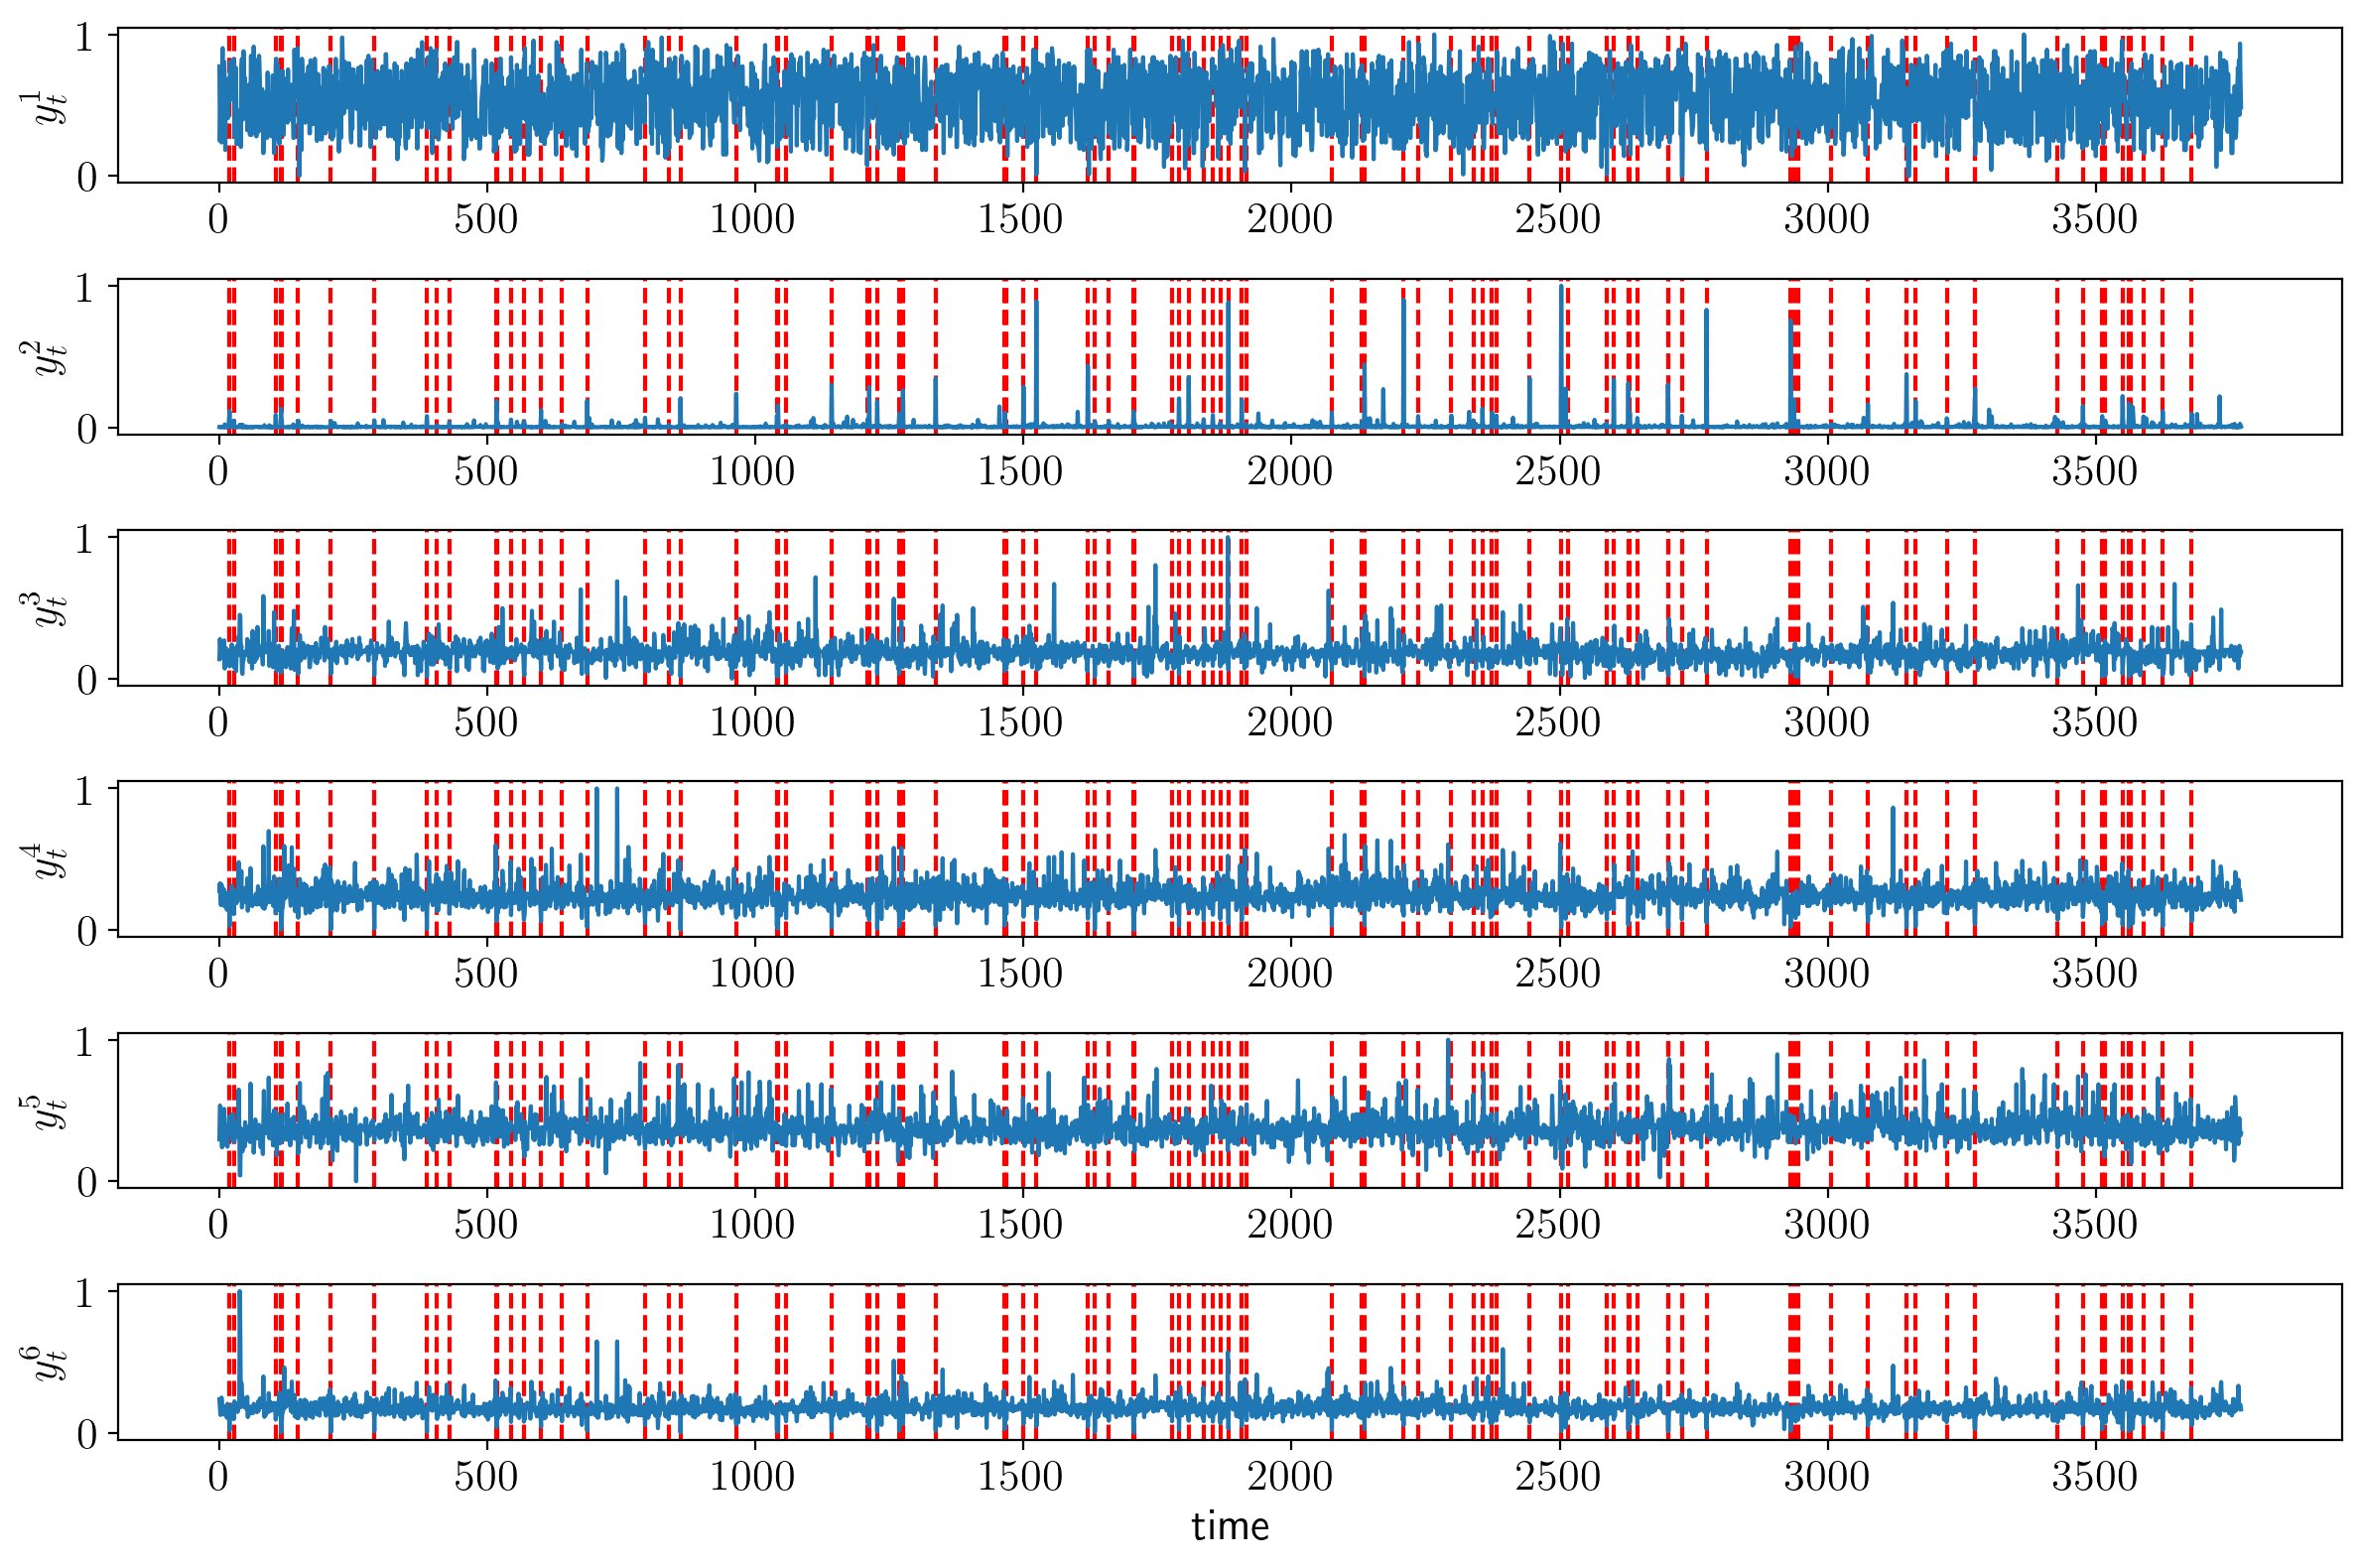

In [31]:
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(12, 8), dpi=200)

axes[0].plot(X[:, 0])
axes[0].set_ylabel(r'$y_{t}^{1}$', fontsize=16)
axes[0].xaxis.set_tick_params(which='both', labelbottom=True)
axes[0].tick_params(labelsize=16)

axes[1].plot(X[:, 1])
axes[1].set_ylabel(r'$y_{t}^{2}$', fontsize=16)
axes[1].xaxis.set_tick_params(which='both', labelbottom=True)
axes[1].tick_params(labelsize=16)

axes[2].plot(X[:, 2])
axes[2].set_ylabel(r'$y_{t}^{3}$', fontsize=16)
axes[2].xaxis.set_tick_params(which='both', labelbottom=True)
axes[2].tick_params(labelsize=16)

axes[3].plot(X[:, 3])
axes[3].set_ylabel(r'$y_{t}^{4}$', fontsize=16)
axes[3].xaxis.set_tick_params(which='both', labelbottom=True)
axes[3].tick_params(labelsize=16)

axes[4].plot(X[:, 4])
axes[4].set_ylabel(r'$y_{t}^{5}$', fontsize=16)
axes[4].xaxis.set_tick_params(which='both', labelbottom=True)
axes[4].tick_params(labelsize=16)

axes[5].plot(X[:, 5])
axes[5].set_xlabel('time', fontsize=16)
axes[5].set_ylabel(r'$y_{t}^{6}$', fontsize=16)
axes[5].xaxis.set_tick_params(which='both', labelbottom=True)
axes[5].tick_params(labelsize=16)

for i in range(len(y)):
    if y[i] == 1:
        axes[0].axvline(i, linestyle='dashed', color='red', zorder=0)
        axes[1].axvline(i, linestyle='dashed', color='red', zorder=0)
        axes[2].axvline(i, linestyle='dashed', color='red', zorder=0)
        axes[3].axvline(i, linestyle='dashed', color='red', zorder=0)
        axes[4].axvline(i, linestyle='dashed', color='red', zorder=0)
        axes[5].axvline(i, linestyle='dashed', color='red', zorder=0)
        
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'plot_thyroid.pdf'), bbox_inches='tight', dpi=200)

In [32]:
np.where(y==1)[0] + 1

array([  20,   28,  106,  116,  117,  148,  209,  290,  388,  407,  430,
        518,  520,  545,  569,  601,  640,  687,  795,  839,  861,  965,
       1041, 1043, 1058, 1143, 1210, 1213, 1228, 1269, 1270, 1276, 1337,
       1466, 1469, 1501, 1525, 1621, 1634, 1660, 1706, 1707, 1778, 1791,
       1809, 1837, 1854, 1868, 1883, 1908, 1917, 2076, 2132, 2137, 2210,
       2237, 2299, 2340, 2357, 2375, 2383, 2445, 2504, 2516, 2589, 2602,
       2629, 2632, 2646, 2703, 2704, 2729, 2775, 2932, 2938, 2946, 3007,
       3076, 3148, 3165, 3223, 3275, 3276, 3430, 3477, 3513, 3519, 3551,
       3563, 3566, 3590, 3626, 3680])

## SDEM

In [33]:
def calc_scores_sdem(X, r, k, alpha=1.0, seed=0):
    np.random.seed(seed)
    rho_const = np.repeat([r], X.shape[0])
    sdem = SDEM(rho_const, alpha, n_components=k)

    sdem.fit(X[:10, :])
    #sdem.weights_ = np.repeat([1/k], k)
    #sdem.means_ = np.hstack([ 
    #                    np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
    #                    for col in range(X.shape[1])
    #                ])
    #sdem.covariances_ = np.stack([np.diag((X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0))/10) for _ in k_list])

    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    anom_scores = [np.nan] * 1000

    n_cluster = pi_est.shape[1]
    #anom_scores = []
    for t in range(1000, pi_est.shape[0]):
        #print('t =', t)
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            #print(sigma_est[t-1, i, :, :])
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :]).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
    anom_scores = np.array(anom_scores)
    
    return anom_scores

In [34]:
n_trial = 5

#r_list = [0.00001, 0.0005, 0.001]
#r_list = [0.0001, 0.0005, 0.001, 0.01]
r_list = [0.01, 0.03, 0.05, 0.1]
k_list = [1, 2, 3]

auc_tr_sdem = np.zeros((n_trial, len(r_list), len(k_list)))
auc_te_sdem = np.zeros((n_trial, len(r_list), len(k_list)))

for n in range(n_trial):
    for i, r in enumerate(r_list):
        for j, k in enumerate(k_list):
            try:
                seed = n*n_trial + i*len(r_list) + j
                anom_scores = calc_scores_sdem(X, r, k, alpha=1.0, seed=seed)

                fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], anom_scores[1000:2000], pos_label=1)
                auc_tr_sdem[n, i, j] = auc(fpr_tr, tpr_tr)

                fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], anom_scores[2000:], pos_label=1)
                auc_te_sdem[n, i, j] = auc(fpr_te, tpr_te)
            except:
                n = n + 1
                continue

100%|██████████| 3772/3772 [00:00<00:00, 4161.48it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 3772/3772 [00:01<00:00, 3447.66it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guida

In [35]:
np.unravel_index(np.argmax(auc_tr_sdem), auc_tr_sdem.shape)

(0, 0, 0)

In [40]:
np.mean(auc_tr_sdem, axis=0)

array([[0.95891189, 0.76616357, 0.        ],
       [0.5728648 , 0.57274406, 0.5728648 ],
       [0.57380234, 0.57418587, 0.57293938],
       [0.57353599, 0.57380589, 0.57255584]])

In [41]:
np.std(auc_tr_sdem, axis=0)

array([[1.11022302e-16, 3.83081786e-01, 0.00000000e+00],
       [4.67742153e-01, 4.67643619e-01, 4.67742153e-01],
       [4.68507646e-01, 4.68820933e-01, 4.67804201e-01],
       [4.68290177e-01, 4.68510805e-01, 4.67493314e-01]])

In [42]:
np.mean(auc_te_sdem, axis=0)

array([[0.93261767, 0.74718965, 0.        ],
       [0.56440958, 0.56388797, 0.56440958],
       [0.56640793, 0.56461602, 0.56734517],
       [0.56506193, 0.56415084, 0.56666254]])

In [43]:
np.std(auc_te_sdem, axis=0)

array([[0.        , 0.37359483, 0.        ],
       [0.46083849, 0.46041363, 0.46083849],
       [0.46247014, 0.46100995, 0.46323642],
       [0.46137114, 0.46063024, 0.46268035]])

In [19]:
auc_tr_sdem[0, 1]

0.9669377463688341

In [20]:
auc_te_sdem[0, 1]

0.9468070465180292

## IEM

In [44]:
def calc_scores_iem(X, k, alpha=1.0, seed=0):
    np.random.seed(seed)
    rhos = 1.0 / np.arange(1, X.shape[0]+1)
    sdem = SDEM(rhos, alpha, n_components=k)

    sdem.fit(X[:10, :])
    #sdem.weights_ = np.repeat([1/k], k)
    #sdem.means_ = np.hstack([ 
    #                    np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
    #                    for col in range(X.shape[1])
    #                ])
    #sdem.covariances_ = np.stack([np.diag((X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0))/10) for _ in k_list])

    for t in tqdm.tqdm(range(X.shape[0])):
        sdem.update(X[t, :])

    pi_est = np.array(sdem.pi_list)
    mu_est = np.array(sdem.means_list)
    sigma_est = np.array(sdem.covariances_list)
    
    anom_scores = [np.nan] * 1000

    n_cluster = pi_est.shape[1]
    #anom_scores = []
    for t in range(1000, pi_est.shape[0]):
        #print('t =', t)
        p = np.zeros(n_cluster)
        for i in range(n_cluster):
            #print(sigma_est[t-1, i, :, :])
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :]).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
    anom_scores = np.array(anom_scores)
    
    return anom_scores

In [45]:
n_trial = 5

k_list = [1, 2, 3]

auc_tr_iem = np.zeros((n_trial, len(k_list)))
auc_te_iem = np.zeros((n_trial, len(k_list)))

for n in range(n_trial):
    for i, k in enumerate(k_list):
        seed = i
        anom_scores = calc_scores_iem(X, k, alpha=1.0, seed=seed)

        fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], anom_scores[1000:2000], pos_label=1)
        auc_tr_iem[n, i] = auc(fpr_tr, tpr_tr)

        fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], anom_scores[2000:], pos_label=1)
        auc_te_iem[n, i] = auc(fpr_te, tpr_te)

100%|██████████| 3772/3772 [00:01<00:00, 3604.81it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 3772/3772 [00:01<00:00, 3622.10it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guida

In [46]:
np.mean(auc_tr_iem, axis=0)

array([0.96349302, 0.96340424, 0.96331546])

In [47]:
np.std(auc_tr_iem, axis=0)

array([1.11022302e-16, 1.11022302e-16, 0.00000000e+00])

In [48]:
np.mean(auc_te_iem, axis=0)

array([0.93506056, 0.9371112 , 0.93547344])

In [49]:
np.std(auc_te_iem, axis=0)

array([1.11022302e-16, 0.00000000e+00, 0.00000000e+00])

In [23]:
auc_tr_iem[np.argmax(auc_tr_iem)]

0.963493021769239

In [24]:
auc_te_iem[np.argmax(auc_tr_iem)]

0.9350605560143133

## sEM

In [50]:
def calc_scores_sem(X, theta0, r, k, seed=0):
    np.random.seed(seed)
    
    rho_const = np.repeat([r], X.shape[0])
    pi_est, mu_est, sigma_est = sem(X, theta0, rho_const)
    
    anom_scores = [np.nan]
    for t in range(1, pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :], allow_singular=True).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
                        
    return anom_scores

In [51]:
n_trial = 5
k_list = [1, 2, 3]
#r_list = [0.0000001, 0.000001, 0.000005]
r_list = [0.0001, 0.001, 0.01]

auc_tr_sem = np.zeros((n_trial, len(r_list), len(k_list)))
auc_te_sem = np.zeros((n_trial, len(r_list), len(k_list)))

for n in range(n_trial):
    for i, r in enumerate(r_list):
        for j, k in enumerate(k_list):
            try:
                seed = i*len(k_list) + j
                np.random.seed(seed)

                pi0 = np.array([1/k] * k).reshape(-1, 1)
                mu0 = np.hstack([ 
                          np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
                          for col in range(X.shape[1])
                      ])
                sigma0 = np.stack([np.diag( (X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0)) /10) for _ in range(k)])
                theta0 = Theta(pi0, mu0, sigma0)

                anom_scores = calc_scores_sem(X, theta0, r, k, seed=seed)

                fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], anom_scores[1000:2000], pos_label=1)
                auc_tr_sem[n, i, j] = auc(fpr_tr, tpr_tr)

                fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], anom_scores[2000:], pos_label=1)
                auc_te_sem[n, i, j] = auc(fpr_te, tpr_te)
            except:
                n = n+1
                continue


  0%|          | 0/3772 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
100%|██████████| 3772/3772 [00:01<00:00, 2922.84it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 3772/3772 [00:02<00:00, 1608.95it/s]


In [52]:
np.mean(auc_tr_sem, axis=0)

array([[0.95599986, 0.95651479, 0.97453745],
       [0.97934941, 0.9793139 , 0.97808871],
       [0.95891189, 0.95662133, 0.96604993]])

In [53]:
np.std(auc_tr_sem, axis=0)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.11022302e-16, 0.00000000e+00, 1.11022302e-16]])

In [54]:
np.mean(auc_te_sem, axis=0)

array([[0.96065923, 0.96299202, 0.98221855],
       [0.96842141, 0.96827691, 0.96370768],
       [0.93261767, 0.94600881, 0.95494082]])

In [55]:
np.std(auc_te_sem, axis=0)

array([[0.00000000e+00, 1.11022302e-16, 0.00000000e+00],
       [0.00000000e+00, 1.11022302e-16, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [27]:
np.unravel_index(np.argmax(auc_tr_sem), auc_tr_sem.shape)

(1, 0)

In [28]:
auc_tr_sem[1, 0]

0.979349408714798

In [29]:
auc_te_sem[1, 0]

0.968421414808698

## SRA

In [56]:
#def calc_scores_sra(X, theta0, k, gamma, d0, M, L_alpha, seed=0):
def calc_scores_sra(X, theta0, k, gamma, ratio, M, seed=0):
    np.random.seed(seed)
    
    #rho = (d0+1) * np.exp(-gamma**2/M**2) / (2.0*L_alpha*gamma)
    rho = ratio * np.exp(-gamma**2/M**2) / (2.0*gamma)
    rho_const = np.repeat(rho, X.shape[0])
    pi_est, mu_est, sigma_est = sra(X, theta0, rho_const, gamma)
    
    anom_scores = []
    for t in range(pi_est.shape[0]):
        p = np.zeros(k)
        for i in range(k):
            p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], sigma_est[t-1, i, :, :], allow_singular=True).pdf(X[t, :])
            #except:
            #    print(nearPD(sigma_est[t-1, i, :, :]))
            #    p_i = pi_est[t-1, i] * multivariate_normal(mu_est[t-1, i, :], nearPD(sigma_est[t-1, i, :, :])).pdf(X[t, :])
            p[i] = p_i
        p_tot = np.sum(p)
        if p_tot >= 1e-16:
            anom_scores.append(-np.log(p_tot))
        else:
            anom_scores.append(-np.log(-1.0/np.finfo(np.float).min))
                        
    return anom_scores

In [57]:
n_trial = 5
k_list = [1, 2, 3]
gamma_list = [5, 10, 15]
ratio_list = [0.1, 0.5, 1.0]
#d0_list = [0.1, 0.5, 1.0]
#d0_list = [1.0, 5.0, 10.0]
#M_list = [0.5, 1.0, 2.0]
M_list = [1.0, 5.0, 10.0]
#L_alpha_list = [0.5, 1.0, 2.0]
#L_alpha_list = [2.0, 10.0, 20.0]

In [59]:
#auc_sra_tot = np.zeros((n_trial, len(k_list), len(gamma_list), len(d0_list), len(M_list), len(L_alpha_list)))
#auc_sra_tr = np.zeros((n_trial, len(k_list), len(gamma_list), len(d0_list), len(M_list), len(L_alpha_list)))
#auc_sra_te = np.zeros((n_trial, len(k_list), len(gamma_list), len(d0_list), len(M_list), len(L_alpha_list)))

auc_sra_tot = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_tr = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))
auc_sra_te = np.zeros((n_trial, len(k_list), len(gamma_list), len(ratio_list), len(M_list)))

for n in range(n_trial):
    for i, k in enumerate(k_list):
        pi0 = np.array([1/k] * k).reshape(-1, 1)
        mu0 = np.hstack([ 
                  np.random.uniform(np.min(X[:2000, col]), np.max(X[:2000, col]), k).reshape(-1, 1)
                  for col in range(X.shape[1])
              ])
        sigma0 = np.stack([np.diag((X[:2000, :].max(axis=0) - X[:2000, :].min(axis=0))/10) for _ in range(k)])
        theta0 = Theta(pi0, mu0, sigma0)
        for j, gamma in enumerate(gamma_list):
            for l, ratio in enumerate(ratio_list):
            #for l, ratio in enumerate([0.01*gamma, 0.1*gamma, gamma]):
                for m, M in enumerate(M_list):
                #for m, M in enumerate([0.1*gamma, gamma, 10*gamma]):
                    scores = calc_scores_sra(X, theta0, k, gamma, ratio, M)
                    fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
                    #auc_sra_tot[n, i, j, l, m, p] = auc(fpr, tpr)
                    auc_sra_tot[n, i, j, l, m] = auc(fpr, tpr)
                    
                    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], scores[1000:2000], pos_label=1)
                    #auc_sra_tr[n, i, j, l, m, p] = auc(fpr_tr, tpr_tr)
                    auc_sra_tr[n, i, j, l, m] = auc(fpr_tr, tpr_tr)
                    
                    fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], scores[2000:], pos_label=1)
                    #auc_sra_te[n, i, j, l, m, p] = auc(fpr_te, tpr_te)
                    auc_sra_te[n, i, j, l, m] = auc(fpr_te, tpr_te)
                    #print('gamma=', gamma, ', ratio=', ratio, ', M=', M, ':', auc_sra_te[n, i, j, l, m, p])
                    print('gamma=', gamma, ', ratio=', ratio, ', M=', M, ':', auc_sra_te[n, i, j, l, m])
            
            """
            for l, d0 in enumerate(d0_list):
                for m, M in enumerate(M_list):
                    for p, L_alpha in enumerate(L_alpha_list):
                        scores = calc_scores_sra(X, theta0, k, gamma, d0, M, L_alpha)
                        fpr, tpr, thresholds = roc_curve(y, scores, pos_label=1)
                        auc_sra_tot[n, i, j, l, m, p] = auc(fpr, tpr)
                        
                        fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], scores[1000:2000], pos_label=1)
                        auc_sra_tr[n, i, j, l, m, p] = auc(fpr_tr, tpr_tr)

                        fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], scores[2000:], pos_label=1)
                        auc_sra_te[n, i, j, l, m, p] = auc(fpr_te, tpr_te)
                        print('gamma=', gamma, ', d0=', d0, ', M=', M, ', L_alpha=', L_alpha, ':', auc_sra_te[n, i, j, l, m, p])
            """

  0%|          | 0/3772 [00:00<?, ?it/s]/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
100%|██████████| 3772/3772 [00:01<00:00, 3395.25it/s]
/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  9%|▉         | 342/3772 [00:00<00:01, 3413.74it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 20%|██        | 759/3772 [00:00<00:00, 3798.95it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 12%|█▏        | 450/3772 [00:00<00:00, 4497.03it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


 10%|▉         | 365/3772 [00:00<00:00, 3648.36it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  9%|▉         | 346/3772 [00:00<00:00, 3451.86it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


 22%|██▏       | 834/3772 [00:00<00:00, 4171.40it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


 18%|█▊        | 688/3772 [00:00<00:00, 3460.09it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 10%|▉         | 369/3772 [00:00<00:00, 3687.63it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


 20%|██        | 763/3772 [00:00<00:00, 3823.03it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


 20%|█▉        | 751/3772 [00:00<00:00, 3760.77it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 21%|██        | 784/3772 [00:00<00:00, 3855.07it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


 19%|█▉        | 725/3772 [00:00<00:00, 3622.97it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


 20%|██        | 772/3772 [00:00<00:00, 3854.89it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 10%|█         | 387/3772 [00:00<00:00, 3859.28it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


 10%|█         | 384/3772 [00:00<00:00, 3833.18it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


  9%|▉         | 354/3772 [00:00<00:00, 3534.00it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▉         | 351/3772 [00:00<00:00, 3504.08it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


  9%|▉         | 331/3772 [00:00<00:01, 3301.78it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  9%|▉         | 345/3772 [00:00<00:00, 3447.13it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  9%|▉         | 358/3772 [00:00<00:00, 3570.65it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


  9%|▊         | 323/3772 [00:00<00:01, 3226.96it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


  9%|▉         | 358/3772 [00:00<00:00, 3566.24it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 19%|█▊        | 703/3772 [00:00<00:00, 3508.56it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


 10%|▉         | 376/3772 [00:00<00:00, 3755.13it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


 19%|█▉        | 729/3772 [00:00<00:00, 3643.88it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 18%|█▊        | 690/3772 [00:00<00:00, 3439.47it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  6%|▌         | 235/3772 [00:00<00:01, 2340.54it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  6%|▌         | 229/3772 [00:00<00:01, 2283.29it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 234/3772 [00:00<00:01, 2339.20it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  6%|▌         | 224/3772 [00:00<00:01, 2235.20it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  6%|▌         | 210/3772 [00:00<00:01, 2090.76it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


 11%|█         | 416/3772 [00:00<00:01, 2072.74it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


 12%|█▏        | 453/3772 [00:00<00:01, 2263.91it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


 12%|█▏        | 460/3772 [00:00<00:01, 2302.18it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  6%|▌         | 229/3772 [00:00<00:01, 2279.90it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  6%|▌         | 235/3772 [00:00<00:01, 2339.68it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


 11%|█         | 416/3772 [00:00<00:01, 2081.32it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 219/3772 [00:00<00:01, 2180.85it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  6%|▌         | 226/3772 [00:00<00:01, 2248.80it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


 12%|█▏        | 447/3772 [00:00<00:01, 2233.96it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  6%|▌         | 219/3772 [00:00<00:01, 2186.29it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  5%|▌         | 205/3772 [00:00<00:01, 2048.57it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  6%|▌         | 211/3772 [00:00<00:01, 2105.22it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  5%|▍         | 173/3772 [00:00<00:02, 1725.71it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  6%|▌         | 215/3772 [00:00<00:01, 2148.47it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  6%|▌         | 228/3772 [00:00<00:01, 2271.88it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 208/3772 [00:00<00:01, 2071.99it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  5%|▌         | 191/3772 [00:00<00:01, 1904.59it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


  6%|▌         | 221/3772 [00:00<00:01, 2195.29it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  5%|▌         | 195/3772 [00:00<00:01, 1947.41it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  5%|▌         | 189/3772 [00:00<00:01, 1878.80it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  5%|▌         | 196/3772 [00:00<00:01, 1951.22it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  6%|▌         | 225/3772 [00:00<00:01, 2246.85it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  4%|▍         | 159/3772 [00:00<00:02, 1589.38it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  4%|▍         | 158/3772 [00:00<00:02, 1579.02it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  4%|▍         | 148/3772 [00:00<00:02, 1476.18it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  4%|▍         | 158/3772 [00:00<00:02, 1578.56it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  7%|▋         | 267/3772 [00:00<00:02, 1333.85it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  7%|▋         | 282/3772 [00:00<00:02, 1413.45it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  4%|▍         | 146/3772 [00:00<00:02, 1454.55it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  4%|▍         | 152/3772 [00:00<00:02, 1513.64it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  4%|▍         | 150/3772 [00:00<00:02, 1497.51it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  4%|▍         | 160/3772 [00:00<00:02, 1597.57it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  4%|▍         | 155/3772 [00:00<00:02, 1544.13it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  3%|▎         | 115/3772 [00:00<00:03, 1139.64it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  4%|▍         | 145/3772 [00:00<00:02, 1445.57it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  4%|▎         | 138/3772 [00:00<00:02, 1370.75it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  4%|▍         | 151/3772 [00:00<00:02, 1506.27it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  4%|▍         | 160/3772 [00:00<00:02, 1597.36it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  4%|▍         | 153/3772 [00:00<00:02, 1524.62it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  4%|▍         | 160/3772 [00:00<00:02, 1590.90it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  4%|▍         | 153/3772 [00:00<00:02, 1522.99it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  4%|▍         | 152/3772 [00:00<00:02, 1510.96it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  8%|▊         | 314/3772 [00:00<00:02, 1561.57it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  4%|▍         | 154/3772 [00:00<00:02, 1530.41it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  8%|▊         | 310/3772 [00:00<00:02, 1550.56it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  4%|▎         | 133/3772 [00:00<00:02, 1329.16it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  4%|▍         | 151/3772 [00:00<00:02, 1504.10it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  4%|▎         | 140/3772 [00:00<00:02, 1394.41it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  4%|▍         | 148/3772 [00:00<00:02, 1471.06it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


 11%|█         | 407/3772 [00:00<00:00, 4068.25it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


 10%|█         | 381/3772 [00:00<00:00, 3799.97it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  9%|▉         | 358/3772 [00:00<00:00, 3575.57it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 17%|█▋        | 640/3772 [00:00<00:00, 3205.50it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


 17%|█▋        | 631/3772 [00:00<00:00, 3162.57it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  9%|▉         | 349/3772 [00:00<00:00, 3482.94it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


 11%|█         | 402/3772 [00:00<00:00, 4012.29it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  8%|▊         | 314/3772 [00:00<00:01, 3132.30it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▊         | 323/3772 [00:00<00:01, 3223.86it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  9%|▊         | 326/3772 [00:00<00:01, 3257.04it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  9%|▉         | 348/3772 [00:00<00:00, 3470.39it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 10%|▉         | 359/3772 [00:00<00:00, 3580.02it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


  5%|▌         | 205/3772 [00:00<00:01, 2046.36it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


  8%|▊         | 291/3772 [00:00<00:01, 2908.86it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  9%|▉         | 355/3772 [00:00<00:00, 3540.36it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


  7%|▋         | 250/3772 [00:00<00:01, 2493.98it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


  8%|▊         | 308/3772 [00:00<00:01, 3072.85it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  7%|▋         | 262/3772 [00:00<00:01, 2615.68it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


  7%|▋         | 274/3772 [00:00<00:01, 2737.42it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  6%|▋         | 236/3772 [00:00<00:01, 2359.01it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  7%|▋         | 262/3772 [00:00<00:01, 2610.83it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


  7%|▋         | 254/3772 [00:00<00:01, 2532.95it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


  9%|▊         | 326/3772 [00:00<00:01, 3259.35it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 10%|▉         | 366/3772 [00:00<00:00, 3659.42it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


 11%|█         | 407/3772 [00:00<00:01, 2082.73it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


 10%|█         | 379/3772 [00:00<00:00, 3782.65it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 18%|█▊        | 677/3772 [00:00<00:00, 3391.07it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  6%|▌         | 220/3772 [00:00<00:01, 2195.98it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  6%|▌         | 211/3772 [00:00<00:01, 2106.53it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


 11%|█         | 414/3772 [00:00<00:01, 2049.67it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


 11%|█         | 421/3772 [00:00<00:01, 2103.23it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


 11%|█         | 417/3772 [00:00<00:01, 2083.27it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  5%|▌         | 207/3772 [00:00<00:01, 2060.73it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


  6%|▌         | 217/3772 [00:00<00:01, 2165.19it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  5%|▌         | 196/3772 [00:00<00:01, 1957.16it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


 11%|█         | 402/3772 [00:00<00:01, 1982.09it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  5%|▌         | 206/3772 [00:00<00:01, 2054.61it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  6%|▌         | 208/3772 [00:00<00:01, 2078.01it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 214/3772 [00:00<00:01, 2133.84it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  5%|▌         | 200/3772 [00:00<00:01, 1992.45it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


 10%|█         | 395/3772 [00:00<00:01, 1984.46it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  5%|▌         | 201/3772 [00:00<00:01, 2002.15it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  5%|▌         | 204/3772 [00:00<00:01, 2034.40it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


 11%|█         | 407/3772 [00:00<00:01, 2037.37it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  6%|▌         | 216/3772 [00:00<00:01, 2154.96it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  6%|▌         | 213/3772 [00:00<00:01, 2124.41it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


 12%|█▏        | 443/3772 [00:00<00:01, 2209.38it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 215/3772 [00:00<00:01, 2140.30it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


 11%|█         | 420/3772 [00:00<00:01, 2099.03it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


 11%|█         | 421/3772 [00:00<00:01, 2103.44it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  6%|▌         | 218/3772 [00:00<00:01, 2170.86it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  6%|▌         | 212/3772 [00:00<00:01, 2114.69it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  6%|▌         | 208/3772 [00:00<00:01, 2071.94it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


 11%|█         | 422/3772 [00:00<00:01, 2100.02it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  3%|▎         | 126/3772 [00:00<00:02, 1252.93it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  4%|▎         | 140/3772 [00:00<00:02, 1394.70it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  3%|▎         | 132/3772 [00:00<00:02, 1317.14it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  3%|▎         | 121/3772 [00:00<00:03, 1208.53it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  4%|▍         | 155/3772 [00:00<00:02, 1542.59it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  4%|▎         | 139/3772 [00:00<00:02, 1388.43it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  4%|▍         | 160/3772 [00:00<00:02, 1594.47it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  8%|▊         | 291/3772 [00:00<00:02, 1456.55it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  4%|▎         | 140/3772 [00:00<00:02, 1396.41it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  4%|▍         | 149/3772 [00:00<00:02, 1484.39it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  4%|▍         | 152/3772 [00:00<00:02, 1510.82it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  4%|▍         | 156/3772 [00:00<00:02, 1555.33it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  8%|▊         | 297/3772 [00:00<00:02, 1482.38it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  4%|▍         | 159/3772 [00:00<00:02, 1581.56it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  4%|▍         | 150/3772 [00:00<00:02, 1492.55it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  4%|▍         | 164/3772 [00:00<00:02, 1636.65it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  4%|▍         | 155/3772 [00:00<00:02, 1545.84it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  8%|▊         | 305/3772 [00:00<00:02, 1520.74it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  4%|▍         | 155/3772 [00:00<00:02, 1548.93it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  4%|▍         | 150/3772 [00:00<00:02, 1492.83it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  4%|▍         | 150/3772 [00:00<00:02, 1499.29it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  4%|▍         | 154/3772 [00:00<00:02, 1539.94it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  4%|▍         | 153/3772 [00:00<00:02, 1524.98it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  8%|▊         | 313/3772 [00:00<00:02, 1563.94it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  8%|▊         | 306/3772 [00:00<00:02, 1526.17it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  3%|▎         | 126/3772 [00:00<00:02, 1254.73it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  3%|▎         | 120/3772 [00:00<00:03, 1192.39it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


  9%|▉         | 331/3772 [00:00<00:01, 3308.70it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


 10%|▉         | 362/3772 [00:00<00:00, 3618.95it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  7%|▋         | 277/3772 [00:00<00:01, 2768.43it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 17%|█▋        | 633/3772 [00:00<00:00, 3160.51it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


  9%|▉         | 342/3772 [00:00<00:01, 3414.50it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  8%|▊         | 288/3772 [00:00<00:01, 2872.93it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


 10%|█         | 382/3772 [00:00<00:00, 3815.68it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


 10%|▉         | 371/3772 [00:00<00:00, 3702.08it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 17%|█▋        | 624/3772 [00:00<00:00, 3161.36it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  9%|▉         | 338/3772 [00:00<00:01, 3378.51it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  8%|▊         | 300/3772 [00:00<00:01, 2994.91it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  8%|▊         | 287/3772 [00:00<00:01, 2863.93it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


  7%|▋         | 281/3772 [00:00<00:01, 2804.53it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


  8%|▊         | 285/3772 [00:00<00:01, 2844.37it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 13%|█▎        | 503/3772 [00:00<00:01, 2519.91it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


 13%|█▎        | 499/3772 [00:00<00:01, 2498.94it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


  8%|▊         | 311/3772 [00:00<00:01, 3104.32it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▊         | 324/3772 [00:00<00:01, 3236.15it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


  7%|▋         | 253/3772 [00:00<00:01, 2529.07it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  6%|▌         | 232/3772 [00:00<00:01, 2316.96it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 16%|█▌        | 586/3772 [00:00<00:01, 2925.37it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


 20%|█▉        | 736/3772 [00:00<00:00, 3687.58it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


 15%|█▌        | 569/3772 [00:00<00:01, 2842.97it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  7%|▋         | 269/3772 [00:00<00:01, 2687.54it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


  7%|▋         | 281/3772 [00:00<00:01, 2804.97it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


  9%|▊         | 325/3772 [00:00<00:01, 3244.19it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  8%|▊         | 306/3772 [00:00<00:01, 3059.36it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  4%|▍         | 161/3772 [00:00<00:02, 1601.23it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  5%|▍         | 172/3772 [00:00<00:02, 1715.14it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  5%|▍         | 179/3772 [00:00<00:02, 1782.33it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  6%|▌         | 223/3772 [00:00<00:01, 2220.01it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  6%|▌         | 220/3772 [00:00<00:01, 2195.41it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  5%|▌         | 193/3772 [00:00<00:01, 1924.71it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


 10%|▉         | 374/3772 [00:00<00:01, 1869.63it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  5%|▍         | 172/3772 [00:00<00:02, 1711.46it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  9%|▊         | 326/3772 [00:00<00:02, 1628.89it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  5%|▍         | 181/3772 [00:00<00:01, 1809.50it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  5%|▍         | 180/3772 [00:00<00:02, 1795.70it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  5%|▍         | 181/3772 [00:00<00:01, 1799.78it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  9%|▉         | 356/3772 [00:00<00:01, 1781.18it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  5%|▍         | 173/3772 [00:00<00:02, 1723.96it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


 10%|▉         | 364/3772 [00:00<00:01, 1817.64it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  4%|▍         | 157/3772 [00:00<00:02, 1563.57it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  5%|▍         | 183/3772 [00:00<00:01, 1828.24it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  4%|▍         | 157/3772 [00:00<00:02, 1566.58it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  8%|▊         | 295/3772 [00:00<00:02, 1475.33it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  4%|▍         | 164/3772 [00:00<00:02, 1631.78it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  8%|▊         | 287/3772 [00:00<00:02, 1431.15it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  3%|▎         | 121/3772 [00:00<00:03, 1204.24it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


 11%|█         | 410/3772 [00:00<00:01, 2052.91it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  6%|▌         | 220/3772 [00:00<00:01, 2197.30it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  6%|▌         | 213/3772 [00:00<00:01, 2126.15it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  6%|▌         | 229/3772 [00:00<00:01, 2285.95it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  6%|▌         | 216/3772 [00:00<00:01, 2151.03it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  4%|▍         | 161/3772 [00:00<00:02, 1604.43it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  4%|▍         | 156/3772 [00:00<00:02, 1556.70it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  4%|▍         | 157/3772 [00:00<00:02, 1562.61it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  8%|▊         | 294/3772 [00:00<00:02, 1471.24it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  4%|▍         | 146/3772 [00:00<00:02, 1454.56it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  4%|▍         | 150/3772 [00:00<00:02, 1498.41it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  8%|▊         | 299/3772 [00:00<00:02, 1500.37it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  4%|▍         | 144/3772 [00:00<00:02, 1439.28it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  4%|▍         | 148/3772 [00:00<00:02, 1474.50it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  4%|▎         | 139/3772 [00:00<00:02, 1388.89it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  4%|▍         | 149/3772 [00:00<00:02, 1489.45it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  8%|▊         | 285/3772 [00:00<00:02, 1417.85it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  3%|▎         | 104/3772 [00:00<00:03, 1036.64it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  3%|▎         | 130/3772 [00:00<00:02, 1295.88it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  4%|▍         | 142/3772 [00:00<00:02, 1419.35it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  4%|▍         | 145/3772 [00:00<00:02, 1442.31it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  4%|▎         | 138/3772 [00:00<00:02, 1375.28it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  4%|▍         | 146/3772 [00:00<00:02, 1450.08it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  4%|▎         | 135/3772 [00:00<00:02, 1341.06it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  4%|▎         | 133/3772 [00:00<00:02, 1321.10it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  4%|▍         | 151/3772 [00:00<00:02, 1507.00it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  4%|▎         | 133/3772 [00:00<00:02, 1323.25it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  4%|▍         | 144/3772 [00:00<00:02, 1432.32it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  4%|▍         | 143/3772 [00:00<00:02, 1428.13it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  4%|▎         | 140/3772 [00:00<00:02, 1392.94it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  4%|▍         | 145/3772 [00:00<00:02, 1443.05it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  4%|▍         | 143/3772 [00:00<00:02, 1419.39it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


 21%|██        | 795/3772 [00:00<00:00, 4017.79it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


 20%|██        | 764/3772 [00:00<00:00, 3820.89it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 10%|▉         | 360/3772 [00:00<00:00, 3597.12it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 20%|██        | 757/3772 [00:00<00:00, 3797.93it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


  9%|▊         | 329/3772 [00:00<00:01, 3285.23it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  9%|▉         | 345/3772 [00:00<00:00, 3443.83it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


 10%|█         | 378/3772 [00:00<00:00, 3771.93it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  9%|▉         | 352/3772 [00:00<00:00, 3510.77it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▊         | 322/3772 [00:00<00:01, 3212.70it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


 18%|█▊        | 683/3772 [00:00<00:00, 3425.57it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


 18%|█▊        | 689/3772 [00:00<00:00, 3459.35it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  9%|▉         | 337/3772 [00:00<00:01, 3362.57it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


  9%|▉         | 332/3772 [00:00<00:01, 3310.53it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


  9%|▉         | 344/3772 [00:00<00:00, 3436.12it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  9%|▉         | 348/3772 [00:00<00:00, 3476.66it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


  9%|▉         | 333/3772 [00:00<00:01, 3323.71it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


 18%|█▊        | 670/3772 [00:00<00:00, 3329.04it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▉         | 335/3772 [00:00<00:01, 3340.87it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


 17%|█▋        | 659/3772 [00:00<00:00, 3297.65it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  9%|▊         | 327/3772 [00:00<00:01, 3265.14it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 18%|█▊        | 664/3772 [00:00<00:00, 3318.32it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


  9%|▉         | 341/3772 [00:00<00:01, 3401.09it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


  8%|▊         | 316/3772 [00:00<00:01, 3152.94it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 17%|█▋        | 660/3772 [00:00<00:00, 3296.66it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


  9%|▉         | 342/3772 [00:00<00:01, 3413.82it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


  9%|▉         | 340/3772 [00:00<00:01, 3393.25it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▉         | 342/3772 [00:00<00:01, 3418.37it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  6%|▌         | 222/3772 [00:00<00:01, 2218.71it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  5%|▌         | 206/3772 [00:00<00:01, 2050.28it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 218/3772 [00:00<00:01, 2175.08it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  6%|▌         | 226/3772 [00:00<00:01, 2258.21it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  6%|▌         | 213/3772 [00:00<00:01, 2129.32it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  6%|▌         | 212/3772 [00:00<00:01, 2111.38it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


 12%|█▏        | 454/3772 [00:00<00:01, 2271.95it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  6%|▌         | 221/3772 [00:00<00:01, 2203.13it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


 11%|█▏        | 425/3772 [00:00<00:01, 2126.16it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  6%|▌         | 216/3772 [00:00<00:01, 2152.70it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  6%|▌         | 212/3772 [00:00<00:01, 2118.39it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


 11%|█▏        | 428/3772 [00:00<00:01, 2143.97it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  6%|▌         | 216/3772 [00:00<00:01, 2157.84it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  6%|▌         | 223/3772 [00:00<00:01, 2220.05it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


 12%|█▏        | 444/3772 [00:00<00:01, 2196.01it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


  6%|▌         | 219/3772 [00:00<00:01, 2186.30it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  6%|▌         | 219/3772 [00:00<00:01, 2180.56it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


 12%|█▏        | 437/3772 [00:00<00:01, 2179.91it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  6%|▌         | 217/3772 [00:00<00:01, 2163.32it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


  6%|▌         | 213/3772 [00:00<00:01, 2125.70it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


 12%|█▏        | 438/3772 [00:00<00:01, 2189.44it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


 12%|█▏        | 442/3772 [00:00<00:01, 2190.32it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


  6%|▌         | 223/3772 [00:00<00:01, 2223.38it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  6%|▌         | 213/3772 [00:00<00:01, 2122.02it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  6%|▌         | 223/3772 [00:00<00:01, 2222.84it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


 12%|█▏        | 438/3772 [00:00<00:01, 2186.68it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


 12%|█▏        | 448/3772 [00:00<00:01, 2209.70it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  4%|▍         | 161/3772 [00:00<00:02, 1605.01it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  4%|▍         | 155/3772 [00:00<00:02, 1541.11it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  4%|▍         | 156/3772 [00:00<00:02, 1550.96it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  4%|▍         | 163/3772 [00:00<00:02, 1620.55it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  4%|▍         | 159/3772 [00:00<00:02, 1580.60it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  8%|▊         | 318/3772 [00:00<00:02, 1587.52it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  4%|▍         | 157/3772 [00:00<00:02, 1562.41it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  4%|▍         | 161/3772 [00:00<00:02, 1608.02it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  4%|▍         | 156/3772 [00:00<00:02, 1559.22it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  8%|▊         | 310/3772 [00:00<00:02, 1549.30it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  4%|▍         | 160/3772 [00:00<00:02, 1598.60it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  4%|▍         | 156/3772 [00:00<00:02, 1554.82it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  4%|▍         | 156/3772 [00:00<00:02, 1554.14it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  4%|▍         | 152/3772 [00:00<00:02, 1510.84it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  4%|▍         | 160/3772 [00:00<00:02, 1594.91it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  4%|▍         | 159/3772 [00:00<00:02, 1584.23it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  8%|▊         | 312/3772 [00:00<00:02, 1555.66it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  4%|▍         | 144/3772 [00:00<00:02, 1437.23it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  4%|▍         | 153/3772 [00:00<00:02, 1521.21it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  4%|▍         | 156/3772 [00:00<00:02, 1551.19it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  4%|▍         | 162/3772 [00:00<00:02, 1614.90it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  4%|▍         | 145/3772 [00:00<00:02, 1440.16it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  8%|▊         | 302/3772 [00:00<00:02, 1509.59it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  8%|▊         | 318/3772 [00:00<00:02, 1594.37it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  4%|▍         | 159/3772 [00:00<00:02, 1582.53it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  8%|▊         | 297/3772 [00:00<00:02, 1487.95it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  4%|▎         | 140/3772 [00:00<00:02, 1397.36it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


  9%|▉         | 353/3772 [00:00<00:00, 3522.95it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


 10%|▉         | 363/3772 [00:00<00:00, 3627.32it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


 10%|▉         | 374/3772 [00:00<00:00, 3734.65it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9499311863473713


 20%|█▉        | 752/3772 [00:00<00:00, 3765.87it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9318676025323425


  9%|▉         | 334/3772 [00:00<00:01, 3336.56it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 19%|█▊        | 700/3772 [00:00<00:00, 3462.18it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9361134048995321


 10%|▉         | 374/3772 [00:00<00:00, 3738.96it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


 10%|█         | 385/3772 [00:00<00:00, 3840.27it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


 19%|█▉        | 708/3772 [00:00<00:00, 3533.93it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  9%|▉         | 356/3772 [00:00<00:00, 3551.02it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


 17%|█▋        | 635/3772 [00:00<00:00, 3182.94it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  9%|▉         | 349/3772 [00:00<00:00, 3479.49it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9589388934764657


 10%|▉         | 360/3772 [00:00<00:00, 3599.71it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9287985136251032


  9%|▉         | 343/3772 [00:00<00:01, 3426.47it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


 10%|▉         | 368/3772 [00:00<00:00, 3671.16it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9825901458849435


 18%|█▊        | 696/3772 [00:00<00:00, 3508.47it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9322254335260116


 20%|██        | 770/3772 [00:00<00:00, 3838.17it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▉         | 332/3772 [00:00<00:01, 3318.41it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9701348747591523


 18%|█▊        | 684/3772 [00:00<00:00, 3400.94it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9361134048995321


  9%|▉         | 347/3772 [00:00<00:00, 3462.62it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9405243600330306


  9%|▉         | 340/3772 [00:00<00:01, 3396.12it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9408064960088082


 10%|█         | 381/3772 [00:00<00:00, 3807.44it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9826451968070465


 10%|▉         | 361/3772 [00:00<00:00, 3607.40it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9405243600330306


  9%|▉         | 354/3772 [00:00<00:00, 3538.27it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9413845306908891


 10%|▉         | 370/3772 [00:00<00:00, 3694.28it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9292526837324526


 19%|█▉        | 719/3772 [00:00<00:00, 3591.26it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9405243600330306


  9%|▉         | 337/3772 [00:00<00:01, 3360.80it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9419763281034957


  6%|▌         | 211/3772 [00:00<00:01, 2101.01it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9292664464629782


  5%|▌         | 206/3772 [00:00<00:01, 2057.86it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 210/3772 [00:00<00:01, 2093.45it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9399669694467382


  6%|▌         | 223/3772 [00:00<00:01, 2229.29it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9452656206991468


  6%|▌         | 209/3772 [00:00<00:01, 2089.75it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  5%|▌         | 201/3772 [00:00<00:01, 2008.54it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.942485549132948


 11%|█         | 417/3772 [00:00<00:01, 2085.85it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9354734379300852


  5%|▌         | 194/3772 [00:00<00:01, 1932.81it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  6%|▌         | 228/3772 [00:00<00:01, 2275.47it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9341590971648775


  6%|▌         | 225/3772 [00:00<00:01, 2247.82it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  5%|▌         | 206/3772 [00:00<00:01, 2053.24it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  5%|▍         | 182/3772 [00:00<00:01, 1812.08it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9769474263693917


  6%|▌         | 230/3772 [00:00<00:01, 2290.02it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.931055601431324


  6%|▌         | 212/3772 [00:00<00:01, 2113.60it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


 12%|█▏        | 462/3772 [00:00<00:01, 2294.67it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9659922928709056


 12%|█▏        | 434/3772 [00:00<00:01, 2167.38it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.9460088081475364


  6%|▌         | 230/3772 [00:00<00:01, 2295.47it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  5%|▌         | 193/3772 [00:00<00:01, 1921.03it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.9460432149738508


  5%|▍         | 182/3772 [00:00<00:01, 1816.31it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.942485549132948


 11%|█         | 418/3772 [00:00<00:01, 2072.83it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9404624277456648


  6%|▌         | 217/3772 [00:00<00:01, 2164.70it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9404624277456648


  6%|▌         | 213/3772 [00:00<00:01, 2122.89it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.9677470410129371


 12%|█▏        | 449/3772 [00:00<00:01, 2250.40it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9404624277456648


  5%|▍         | 188/3772 [00:00<00:01, 1878.01it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9410404624277456


  5%|▌         | 190/3772 [00:00<00:01, 1889.77it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9304362785576659


  5%|▌         | 196/3772 [00:00<00:01, 1955.74it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9404624277456648


  6%|▌         | 213/3772 [00:00<00:01, 2120.31it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9399325626204239


  4%|▍         | 153/3772 [00:00<00:02, 1523.15it/s]

gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9396091384530691


  4%|▍         | 155/3772 [00:00<00:02, 1542.28it/s]

gamma= 5 , ratio= 0.1 , M= 1.0 : 0.9431323974676576


  3%|▎         | 126/3772 [00:00<00:02, 1250.71it/s]

gamma= 5 , ratio= 0.1 , M= 5.0 : 0.9427470410129369


  7%|▋         | 282/3772 [00:00<00:02, 1407.19it/s]

gamma= 5 , ratio= 0.1 , M= 10.0 : 0.9437517203413157


  4%|▍         | 142/3772 [00:00<00:02, 1411.91it/s]

gamma= 5 , ratio= 0.5 , M= 1.0 : 0.9431323974676576


  4%|▍         | 145/3772 [00:00<00:02, 1440.16it/s]

gamma= 5 , ratio= 0.5 , M= 5.0 : 0.9423892100192678


  4%|▍         | 152/3772 [00:00<00:02, 1516.67it/s]

gamma= 5 , ratio= 0.5 , M= 10.0 : 0.9454720616570327


  9%|▊         | 324/3772 [00:00<00:02, 1624.37it/s]

gamma= 5 , ratio= 1.0 , M= 1.0 : 0.9431323974676576


  7%|▋         | 276/3772 [00:00<00:02, 1374.74it/s]

gamma= 5 , ratio= 1.0 , M= 5.0 : 0.9453757225433526


  4%|▍         | 163/3772 [00:00<00:02, 1620.79it/s]

gamma= 5 , ratio= 1.0 , M= 10.0 : 0.9725708780622075


  7%|▋         | 271/3772 [00:00<00:02, 1368.04it/s]

gamma= 10 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  4%|▍         | 148/3772 [00:00<00:02, 1470.19it/s]

gamma= 10 , ratio= 0.1 , M= 5.0 : 0.9810624827965868


  4%|▎         | 141/3772 [00:00<00:02, 1407.34it/s]

gamma= 10 , ratio= 0.1 , M= 10.0 : 0.9369804569226534


  4%|▍         | 156/3772 [00:00<00:02, 1556.70it/s]

gamma= 10 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  8%|▊         | 292/3772 [00:00<00:02, 1466.18it/s]

gamma= 10 , ratio= 0.5 , M= 5.0 : 0.9720203688411782


  7%|▋         | 270/3772 [00:00<00:02, 1371.02it/s]

gamma= 10 , ratio= 0.5 , M= 10.0 : 0.943999449490779


  4%|▎         | 136/3772 [00:00<00:02, 1351.93it/s]

gamma= 10 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  9%|▉         | 332/3772 [00:00<00:02, 1667.84it/s]

gamma= 10 , ratio= 1.0 , M= 5.0 : 0.935390861546931


  4%|▍         | 167/3772 [00:00<00:02, 1664.16it/s]

gamma= 10 , ratio= 1.0 , M= 10.0 : 0.9423892100192678


  4%|▍         | 147/3772 [00:00<00:02, 1469.00it/s]

gamma= 15 , ratio= 0.1 , M= 1.0 : 0.9431323974676575


  4%|▍         | 159/3772 [00:00<00:02, 1586.65it/s]

gamma= 15 , ratio= 0.1 , M= 5.0 : 0.9434282961739608


  8%|▊         | 293/3772 [00:00<00:02, 1477.01it/s]

gamma= 15 , ratio= 0.1 , M= 10.0 : 0.975419763281035


  3%|▎         | 132/3772 [00:00<00:02, 1317.71it/s]

gamma= 15 , ratio= 0.5 , M= 1.0 : 0.9431323974676575


  4%|▍         | 151/3772 [00:00<00:02, 1501.17it/s]

gamma= 15 , ratio= 0.5 , M= 5.0 : 0.9448940269749518


  2%|▏         | 91/3772 [00:00<00:04, 909.70it/s]

gamma= 15 , ratio= 0.5 , M= 10.0 : 0.9366088631984586


  4%|▎         | 140/3772 [00:00<00:02, 1393.00it/s]

gamma= 15 , ratio= 1.0 , M= 1.0 : 0.9431323974676575


  4%|▎         | 138/3772 [00:00<00:02, 1369.47it/s]

gamma= 15 , ratio= 1.0 , M= 5.0 : 0.9464010459675201


100%|██████████| 3772/3772 [00:02<00:00, 1436.83it/s]


gamma= 15 , ratio= 1.0 , M= 10.0 : 0.9424167354803192


In [60]:
np.mean(auc_sra_tr, axis=0)

array([[[[0.95056643, 0.95544941, 0.95983522],
         [0.95056643, 0.95601761, 0.96038567],
         [0.95056643, 0.9604922 , 0.95990625]],

        [[0.95056643, 0.9550055 , 0.97478604],
         [0.95056643, 0.97592244, 0.95926702],
         [0.95056643, 0.97915409, 0.95601761]],

        [[0.95056643, 0.95056643, 0.97361412],
         [0.95056643, 0.95056643, 0.97505238],
         [0.95056643, 0.95056643, 0.96466494]]],


       [[[0.95005149, 0.96347527, 0.95846799],
         [0.95005149, 0.94948329, 0.9465535 ],
         [0.95005149, 0.94680209, 0.95990625]],

        [[0.95005149, 0.96604993, 0.97084414],
         [0.95005149, 0.97901204, 0.95697646],
         [0.95005149, 0.97038247, 0.94948329]],

        [[0.95005149, 0.95005149, 0.97936717],
         [0.95005149, 0.95005149, 0.97151887],
         [0.95005149, 0.95056643, 0.96363507]]],


       [[[0.95211123, 0.96317341, 0.95880536],
         [0.95211123, 0.94941227, 0.96026137],
         [0.95211123, 0.96388366, 0.95990625

In [61]:
np.std(auc_sra_tr, axis=0)

array([[[[0.00000000e+00, 1.11022302e-16, 0.00000000e+00],
         [0.00000000e+00, 1.11022302e-16, 1.11022302e-16],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 1.11022302e-16],
         [0.00000000e+00, 1.11022302e-16, 0.00000000e+00],
         [0.00000000e+00, 1.11022302e-16, 1.11022302e-16]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]],


       [[[1.11022302e-16, 0.00000000e+00, 1.11022302e-16],
         [1.11022302e-16, 0.00000000e+00, 1.11022302e-16],
         [1.11022302e-16, 0.00000000e+00, 0.00000000e+00]],

        [[1.11022302e-16, 0.00000000e+00, 1.11022302e-16],
         [1.11022302e-16, 0.00000000e+00, 1.11022302e-16],
         [1.11022302e-16, 0.00000000e+00, 0.00000000e+00]],

        [[1.11022302e-16, 1.11022302e-16, 0.00000000e+00],
         [1.11022302e-16, 1.11022302e-16, 0.

In [62]:
np.mean(auc_sra_te, axis=0)

array([[[[0.94052436, 0.94993119, 0.9318676 ],
         [0.94052436, 0.9361134 , 0.94547206],
         [0.94052436, 0.94537572, 0.97257088]],

        [[0.94052436, 0.95893889, 0.92879851],
         [0.94052436, 0.98259015, 0.93222543],
         [0.94052436, 0.97013487, 0.9361134 ]],

        [[0.94052436, 0.9408065 , 0.9826452 ],
         [0.94052436, 0.94138453, 0.92925268],
         [0.94052436, 0.94197633, 0.92926645]]],


       [[[0.94046243, 0.93996697, 0.94526562],
         [0.94046243, 0.94248555, 0.93547344],
         [0.94046243, 0.9341591 , 0.97257088]],

        [[0.94046243, 0.97694743, 0.9310556 ],
         [0.94046243, 0.96599229, 0.94600881],
         [0.94046243, 0.94604321, 0.94248555]],

        [[0.94046243, 0.94046243, 0.96774704],
         [0.94046243, 0.94104046, 0.93043628],
         [0.94046243, 0.93993256, 0.93960914]]],


       [[[0.9431324 , 0.94274704, 0.94375172],
         [0.9431324 , 0.94238921, 0.94547206],
         [0.9431324 , 0.94537572, 0.97257088

In [63]:
np.std(auc_sra_te, axis=0)

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 1.11022302e-16]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.11022302e-16, 0.00000000e+00]]],


       [[[0.00000000e+00, 1.11022302e-16, 1.11022302e-16],
         [0.00000000e+00, 1.11022302e-16, 1.11022302e-16],
         [0.00000000e+00, 0.00000000e+00, 1.11022302e-16]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.11022302e-16, 1.11022302e-16]],

        [[0.00000000e+00, 0.00000000e+00, 1.11022302e-16],
         [0.00000000e+00, 0.00000000e+00, 0.

In [33]:
np.unravel_index(np.argmax(np.mean(auc_sra_tr, axis=0)), np.mean(auc_sra_tr, axis=0).shape)

(2, 1, 1, 1)

In [36]:
np.mean(auc_sra_tr, axis=0)[2, 1, 1, 1]

0.9810007457651195

In [37]:
np.mean(auc_sra_te, axis=0)[2, 1, 1, 1]

0.9720203688411783

In [38]:
np.std(auc_sra_te, axis=0)[0, 1, 0, 1]

0.0

# ADWIN

In [39]:
from math import log, sqrt, fabs

import os, sys
#sys.path.append('./')

"""
Within one bucket row, each bucket contains same number of original data.
New buckets are added at the end of bucket row.
When old buckets need to be removed, they are taken from the head of this bucket row.
"""


class AdwinBucketRow:
    def __init__(self, max_buckets=5, next_bucket_row=None, previous_bucket_row=None):
        """
        :param max_buckets: Max bucket with one row
        :param next_bucket_row: Following bucket row
        :param previous_bucket_row: Previous bucket row
        """
        self.max_buckets = max_buckets

        # Current count of buckets in this bucket row
        self.bucket_count = 0

        self.next_bucket_row = next_bucket_row
        # Set previous bucket row connect to this bucket row
        if next_bucket_row is not None:
            next_bucket_row.previous_bucket_row = self

        self.previous_bucket_row = previous_bucket_row
        # Set next bucket connect to this bucket
        if previous_bucket_row is not None:
            previous_bucket_row.next_bucket_row = self

        # Init statistic number for each bucket
        self.bucket_sum = np.zeros(self.max_buckets + 1)
        self.bucket_variance = np.zeros(self.max_buckets + 1)

    def insert_bucket(self, value, variance):
        """
        Insert a new bucket at the end.
        """
        self.bucket_sum[self.bucket_count] = value
        self.bucket_variance[self.bucket_count] = variance
        self.bucket_count += 1

    def compress_bucket(self, number_deleted):
        """
        Remove the oldest buckets.
        """
        delete_index = self.max_buckets - number_deleted + 1
        self.bucket_sum[:delete_index] = self.bucket_sum[number_deleted:]
        self.bucket_sum[delete_index:] = np.zeros(number_deleted)

        self.bucket_variance[:delete_index] = self.bucket_variance[number_deleted:]
        self.bucket_variance[delete_index:] = np.zeros(number_deleted)

        self.bucket_count -= number_deleted

"""
List of bucket rows.
Add new bucket row at head of window, remove old bucket row from tail of window.
"""

class AdwinRowBucketList:
    def __init__(self, max_buckets=5):
        """
        :param max_buckets: Max number of bucket in each bucket row
        """
        self.max_buckets = max_buckets

        self.count = 0
        self.head = None
        self.tail = None
        self.__add_to_head()

    def __add_to_head(self):
        """
        Init bucket row list.
        """
        self.head = AdwinBucketRow(self.max_buckets, next_bucket_row=self.head)
        if self.tail is None:
            self.tail = self.head
        self.count += 1

    def add_to_tail(self):
        """
        Add the bucket row at the end of the window.
        """
        self.tail = AdwinBucketRow(self.max_buckets, previous_bucket_row=self.tail)
        if self.head is None:
            self.head = self.tail
        self.count += 1

    def remove_from_tail(self):
        """
        Remove the last bucket row in the window.
        """
        self.tail = self.tail.previous_bucket_row
        if self.tail is None:
            self.head = None
        else:
            self.tail.next_bucket_row = None
        self.count -= 1

class AdWin:
    def __init__(self, delta=0.002, max_buckets=5, min_clock=32, min_win_len=10, min_sub_win_len=5):
        """
        :param delta: Confidence value
        :param max_buckets: Max number of buckets within one bucket row
        :param min_clock: Min number of new data for starting to reduce window and detect change
        :param min_win_len: Min window length for starting to reduce window and detect change
        :param min_sub_win_len: Min sub-window length, which is split from whole window
        """
        self.delta = delta
        self.max_buckets = max_buckets
        self.min_clock = min_clock
        self.min_win_len = min_win_len
        self.min_sub_win_len = min_sub_win_len

        # Time is used for comparison with min_clock parameter
        self.time = 0
        # Current window length
        self.window_len = 0
        # Sum of all values in the window
        self.window_sum = 0.0
        # Variance of all values in the window
        self.window_variance = 0.0

        # Count of bucket row within window
        self.bucket_row_count = 0
        # Init bucket list
        self.bucket_row_list = AdwinRowBucketList(self.max_buckets)

    def set_input(self, value):
        """
        Main method for adding a new data value and automatically detect a possible concept drift.
        :param value: new data value
        :return: true if there is a concept drift, otherwise false
        """
        self.time += 1

        # Insert the new element
        self.__insert_element(value)

        # Reduce window
        return self.__reduce_window()

    def __insert_element(self, value):
        """
        Create a new bucket, and insert it into bucket row which is the head of bucket row list.
        Meanwhile, this bucket row maybe compressed if reaches the maximum number of buckets.
        :param value: New data value from the stream
        """
        # Insert the new bucket
        self.bucket_row_list.head.insert_bucket(value, 0)

        # Calculate the incremental variance
        incremental_variance = 0
        if self.window_len > 0:
            mean = self.window_sum / self.window_len
            incremental_variance = self.window_len * pow(value - mean, 2) / (self.window_len + 1)

        # Update statistic value
        self.window_len += 1
        self.window_variance += incremental_variance
        self.window_sum += value

        # Compress buckets if necessary
        self.__compress_bucket_row()

    def __compress_bucket_row(self):
        """
        If reaches maximum number of buckets, then merge two buckets within one row into a next bucket row.
        """
        bucket_row = self.bucket_row_list.head
        bucket_row_level = 0
        while bucket_row is not None:
            # Merge buckets if row is full
            if bucket_row.bucket_count == self.max_buckets + 1:
                next_bucket_row = bucket_row.next_bucket_row
                if next_bucket_row is None:
                    # Add new bucket row and move to it
                    self.bucket_row_list.add_to_tail()
                    next_bucket_row = bucket_row.next_bucket_row
                    self.bucket_row_count += 1

                # Calculate number of bucket which will be compressed into next bucket row
                n_1 = pow(2, bucket_row_level)
                n_2 = pow(2, bucket_row_level)
                # Mean
                mean_1 = bucket_row.bucket_sum[0] / n_1
                mean_2 = bucket_row.bucket_sum[1] / n_2
                # Total
                next_total = bucket_row.bucket_sum[0] + bucket_row.bucket_sum[1]
                # Variance
                external_variance = n_1 * n_2 * pow(mean_1 - mean_2, 2) / (n_1 + n_2)
                next_variance = bucket_row.bucket_variance[0] + bucket_row.bucket_variance[1] + external_variance

                # Insert into next bucket row, meanwhile remove two original buckets
                next_bucket_row.insert_bucket(next_total, next_variance)

                # Compress those tow buckets
                bucket_row.compress_bucket(2)

                # Stop if the number of bucket within one row, which does not exceed limited
                if next_bucket_row.bucket_count <= self.max_buckets:
                    break
            else:
                break

            # Move to next bucket row
            bucket_row = bucket_row.next_bucket_row
            bucket_row_level += 1

    def __reduce_window(self):
        """
        Detect a change from last of each bucket row, reduce the window if there is a concept drift.
        :return: boolean: Whether has changed
        """
        is_changed = False
        if self.time % self.min_clock == 0 and self.window_len > self.min_win_len:
            is_reduced_width = True
            while is_reduced_width:
                is_reduced_width = False
                is_exit = False
                n_0, n_1 = 0, self.window_len
                sum_0, sum_1 = 0, self.window_sum

                # Start building sub windows from the tail of window (old bucket row)
                bucket_row = self.bucket_row_list.tail
                i = self.bucket_row_count
                while (not is_exit) and (bucket_row is not None):
                    for bucket_num in range(bucket_row.bucket_count):
                        # Iteration of last bucket row, or last bucket in one row
                        if i == 0 and bucket_num == bucket_row.bucket_count - 1:
                            is_exit = True
                            break

                        # Grow sub window 0, while reduce sub window 1
                        n_0 += pow(2, i)
                        n_1 -= pow(2, i)
                        sum_0 += bucket_row.bucket_sum[bucket_num]
                        sum_1 -= bucket_row.bucket_sum[bucket_num]
                        diff_value = (sum_0 / n_0) - (sum_1 / n_1)

                        # Minimum sub window length is matching
                        if n_0 > self.min_sub_win_len + 1 and n_1 > self.min_sub_win_len + 1:
                            # Remove oldest bucket if there is a concept drift
                            if self.__reduce_expression(n_0, n_1, diff_value):
                                is_reduced_width, is_changed = True, True
                                if self.window_len > 0:
                                    n_0 -= self.__delete_element()
                                    is_exit = True
                                    break

                    # Move to previous bucket row
                    bucket_row = bucket_row.previous_bucket_row
                    i -= 1
        return is_changed

    def __reduce_expression(self, n_0, n_1, diff_value):
        """
        Calculate epsilon cut value.
        :param n_0: number of elements in sub window 0
        :param n_1: number of elements in sub window 1
        :param diff_value: difference of mean values of both sub windows
        :return: true if difference of mean values is higher than epsilon_cut
        """
        # Harmonic mean of n0 and n1
        m = 1 / (n_0 - self.min_sub_win_len + 1) + 1 / (n_1 - self.min_sub_win_len + 1)
        d = log(2 * log(self.window_len) / self.delta)
        variance_window = self.window_variance / self.window_len
        epsilon_cut = sqrt(2 * m * variance_window * d) + 2 / 3 * m * d
        return fabs(diff_value) > epsilon_cut

    def __delete_element(self):
        """
        Remove a bucket from tail of bucket row.
        :return: Number of elements to be deleted
        """
        bucket_row = self.bucket_row_list.tail
        deleted_number = pow(2, self.bucket_row_count)
        self.window_len -= deleted_number
        self.window_sum -= bucket_row.bucket_sum[0]

        deleted_bucket_mean = bucket_row.bucket_sum[0] / deleted_number
        inc_variance = bucket_row.bucket_variance[0] + deleted_number * self.window_len * pow(
            deleted_bucket_mean - self.window_sum / self.window_len, 2
        ) / (deleted_number + self.window_len)

        self.window_variance -= inc_variance

        # Delete bucket from bucket row
        bucket_row.compress_bucket(1)
        # If bucket row is empty, remove it from the tail of window
        if bucket_row.bucket_count == 0:
            self.bucket_row_list.remove_from_tail()
            self.bucket_row_count -= 1

        return deleted_number


In [57]:
n_trial = 5

delta_list_adwin=[0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

score_start = 0
score_end = None

#auc_adwin_tr = np.nan * np.ones((n_trial, len(delta_list_adwin), X.shape[1]))
#auc_adwin_te = np.nan * np.ones((n_trial, len(delta_list_adwin), X.shape[1]))

res_adwin_tr = []
res_adwin_te = []

for n in range(n_trial):
    for i, delta in enumerate(delta_list_adwin):
        score_list_adwin = []

        auc_all = []
        for j in range(X.shape[1]):
            adwin = AdWin(delta=delta)
            score_list_adwin_j = []
            for t, x in enumerate(X[:, j]):
                prev_lenwin = adwin.window_len
                if adwin.set_input(x):
                    post_lenwin = adwin.window_len
                    score = prev_lenwin - post_lenwin + 1
                    score_list_adwin_j.append(score)
                else:
                    score_list_adwin_j.append(1.0)
            score_list_adwin_j = np.hstack((np.nan, np.abs(np.diff(score_list_adwin_j))))

            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], score_list_adwin_j[1000:2000], pos_label=1)
            #auc_adwin_tr[n, i, j] = auc(fpr_tr, tpr_tr)
            res_adwin_tr.append([n, delta, j, auc(fpr_tr, tpr_tr)])
            
            fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], score_list_adwin_j[2000:], pos_label=1)
            #auc_adwin_te[n, i, j] = auc(fpr_te, tpr_te)
            res_adwin_te.append([n, delta, j, auc(fpr_te, tpr_te)])

In [58]:
score_list_adwin_j

array([nan,  0.,  0., ...,  0.,  0.,  0.])

In [59]:
res_adwin_tr_df = pd.DataFrame(res_adwin_tr, columns=['n', 'delta', 'column', 'auc'])
res_adwin_te_df = pd.DataFrame(res_adwin_te, columns=['n', 'delta', 'column', 'auc'])

In [60]:
res_adwin_tr_df.groupby(['delta', 'column'])['auc'].agg([np.mean, np.std])

mean  std
delta column           
0.001 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.002 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.005 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.010 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.020 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.050 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.100 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.200 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0
0.500 0        0.5  0.0
      1        0.5  0.0
      2        0.5  0.0
      3        0.5  0.0
      4        0.5  0.0
      5        0.5  0.0

In [61]:
 res_adwin_te_df.groupby(['delta', 'column'])['auc'].agg([np.mean, np.std])

mean  std
delta column               
0.001 0       0.500000  0.0
      1       0.500000  0.0
      2       0.500000  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.002 0       0.500000  0.0
      1       0.500000  0.0
      2       0.500000  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.005 0       0.500000  0.0
      1       0.500000  0.0
      2       0.500000  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.010 0       0.500000  0.0
      1       0.500000  0.0
      2       0.500000  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.020 0       0.500000  0.0
      1       0.500000  0.0
      2       0.499422  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.050 0       0.500000  0.0
      1       0.500000  0.0
      2       0.498844  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.100 0       0.500000  0.0
      1       0.500000  0.0
      2       0.498266  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.200 0       0.500000  0.0
      1       0.500000  0.0
      2       0.498266  0.0
      3       0.500000  0.0
      4       0.500000  0.0
      5       0.500000  0.0
0.500 0       0.500000  0.0
      1       0.500000  0.0
      2       0.498266  0.0
      3       0.500000  0.0
      4       0.499422  0.0
      5       0.500000  0.0

# KSWIN

In [77]:
alpha_list_kswin = [0.001, 0.005, 0.01]
window_size_list_kswin = [20, 30]
stat_size_list_kswin = [10, 15]

res_kswin_tr = []
res_kswin_te = []

for n in range(n_trial):
    for i, alpha in enumerate(alpha_list_kswin):
        for j, window_size in enumerate(window_size_list_kswin):
            for k, stat_size in enumerate(stat_size_list_kswin):
                for l in range(X.shape[1]):
                    kswin = KSWIN(alpha=alpha, window_size=window_size, stat_size=stat_size)
                    score_list_kswin_l = []
                    for t, x in enumerate(X[:, l]):
                        kswin.add_element(x)

                        #if kswin.detected_change():
                        #    score = 1.0
                        #else:
                        #    score = 0.0
                        currentLength = kswin.window.shape[0]
                        if currentLength >= kswin.window_size:
                            window = np.delete(kswin.window, 0)
                            rnd_window = np.random.choice(kswin.window[:stat_size], stat_size)

                            (st, p_value) = ks_2samp(rnd_window, kswin.window[-stat_size:], mode="exact")

                            score = 1.0 - p_value
                        else:
                            score = 0.0

                        score_list_kswin_l.append(score)

                    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], score_list_kswin_l[1000:2000], pos_label=1)
                    res_kswin_tr.append([n, alpha, window_size, stat_size, l, auc(fpr_tr, tpr_tr)])

                    fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], score_list_kswin_l[2000:], pos_label=1)
                    res_kswin_te.append([n, alpha, window_size, stat_size, l, auc(fpr_te, tpr_te)])


/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to mode=asymp.
  f"Switching to mode={mode}.", RuntimeWarning)


In [78]:
res_kswin_tr_df = pd.DataFrame(res_kswin_tr, columns=['n', 'alpha', 'window_size', 'stat_size', 'column', 'auc'])
res_kswin_te_df = pd.DataFrame(res_kswin_te, columns=['n', 'alpha', 'window_size', 'stat_size', 'column', 'auc'])

In [79]:
res_kswin_tr_df.groupby(['alpha', 'window_size', 'stat_size', 'column'])['auc'].agg([np.mean, np.std])

mean       std
alpha window_size stat_size column                    
0.001 20          10        0       0.534113  0.040815
                            1       0.510292  0.052772
                            2       0.568628  0.048726
                            3       0.488611  0.031393
                            4       0.559121  0.045193
                            5       0.471902  0.023649
                  15        0       0.503239  0.059311
                            1       0.469978  0.039367
                            2       0.495334  0.048592
                            3       0.559739  0.041085
                            4       0.526808  0.037046
                            5       0.523733  0.049732
      30          10        0       0.503661  0.048855
                            1       0.465681  0.037944
                            2       0.537143  0.050454
                            3       0.493547  0.033391
                            4       0.552115  0.051359
                            5       0.470002  0.049144
                  15        0       0.481874  0.060754
                            1       0.518587  0.058008
                            2       0.507010  0.029319
                            3       0.474339  0.017063
                            4       0.575589  0.057637
                            5       0.504780  0.047125
0.005 20          10        0       0.497141  0.018213
                            1       0.484506  0.033330
                            2       0.579104  0.039545
                            3       0.461973  0.036033
                            4       0.511570  0.025917
                            5       0.499592  0.020548
                  15        0       0.472556  0.024968
                            1       0.456636  0.036576
                            2       0.469037  0.053224
                            3       0.509738  0.045540
                            4       0.461902  0.024732
                            5       0.510167  0.032224
      30          10        0       0.555158  0.083038
                            1       0.491026  0.036092
                            2       0.508207  0.019807
                            3       0.474800  0.028152
                            4       0.535339  0.050766
                            5       0.475450  0.057139
                  15        0       0.515757  0.035614
                            1       0.546862  0.038337
                            2       0.448610  0.061129
                            3       0.525988  0.040867
                            4       0.534792  0.046407
                            5       0.470571  0.048415
0.010 20          10        0       0.467293  0.051539
                            1       0.494385  0.039827
                            2       0.592383  0.033532
                            3       0.432583  0.028087
                            4       0.543716  0.031564
                            5       0.532114  0.030439
                  15        0       0.503217  0.039884
                            1       0.432753  0.038739
                            2       0.518985  0.029682
                            3       0.451419  0.014137
                            4       0.449149  0.035467
                            5       0.484406  0.059146
      30          10        0       0.550875  0.050043
                            1       0.476036  0.057008
                            2       0.515459  0.057334
                            3       0.483796  0.079748
                            4       0.556604  0.043793
                            5       0.526031  0.018985
                  15        0       0.494680  0.038269
                            1       0.500174  0.040041
                            2       0.470926  0.022660
                            3       0.477975  0.028123
                            4       0.513782  0.059392
                         

In [80]:
res_kswin_te_df.groupby(['alpha', 'window_size', 'stat_size', 'column'])['auc'].agg([np.mean, np.std])

mean       std
alpha window_size stat_size column                    
0.001 20          10        0       0.520969  0.033720
                            1       0.500143  0.037388
                            2       0.555856  0.047606
                            3       0.523409  0.029056
                            4       0.437704  0.008493
                            5       0.472476  0.024862
                  15        0       0.587091  0.040594
                            1       0.489449  0.043997
                            2       0.515343  0.034511
                            3       0.460795  0.041547
                            4       0.533915  0.043799
                            5       0.435021  0.033643
      30          10        0       0.498797  0.018793
                            1       0.491314  0.025475
                            2       0.520211  0.018186
                            3       0.518665  0.021470
                            4       0.527348  0.051081
                            5       0.487122  0.053573
                  15        0       0.493292  0.035221
                            1       0.492399  0.019877
                            2       0.487040  0.047119
                            3       0.539682  0.042421
                            4       0.570729  0.042988
                            5       0.494511  0.038813
0.005 20          10        0       0.511635  0.040369
                            1       0.478591  0.053934
                            2       0.477691  0.026958
                            3       0.493472  0.051708
                            4       0.469375  0.048335
                            5       0.448739  0.036615
                  15        0       0.544605  0.044966
                            1       0.506109  0.062590
                            2       0.501541  0.020093
                            3       0.432128  0.023474
                            4       0.503585  0.036830
                            5       0.450628  0.021123
      30          10        0       0.511514  0.037019
                            1       0.495014  0.021458
                            2       0.507865  0.028080
                            3       0.495714  0.042622
                            4       0.531546  0.049167
                            5       0.499361  0.020646
                  15        0       0.541091  0.019455
                            1       0.523708  0.027709
                            2       0.478732  0.049755
                            3       0.553465  0.036441
                            4       0.530143  0.043978
                            5       0.510798  0.032737
0.010 20          10        0       0.531400  0.046314
                            1       0.472987  0.018647
                            2       0.514601  0.054717
                            3       0.539399  0.029239
                            4       0.486971  0.032342
                            5       0.478211  0.041717
                  15        0       0.518756  0.013294
                            1       0.492074  0.035372
                            2       0.508998  0.056419
                            3       0.425934  0.027806
                            4       0.545984  0.018132
                            5       0.442086  0.050869
      30          10        0       0.540131  0.052947
                            1       0.513904  0.047920
                            2       0.489390  0.069478
                            3       0.510194  0.043236
                            4       0.538274  0.041935
                            5       0.455629  0.041344
                  15        0       0.562885  0.037128
                            1       0.491402  0.051567
                            2       0.464088  0.040533
                            3       0.576943  0.025685
                            4       0.555517  0.046731
                         

# PH

In [81]:
n_trial = 5

#threshold_list_ph = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
threshold_list_ph = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
alpha_list_ph = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 0.999]

res_ph_tr = []
res_ph_te = []

for n in range(n_trial):
    for i, threshold in enumerate(threshold_list_ph):
        #for j, alpha in enumerate(alpha_list_ph):
        auc_all = []
        for k in range(X.shape[1]):
            ph = PageHinkley()
            score_list_ph_k = []
            for t, x in enumerate(X[:, k]):
                ph.add_element(x)
                score_t = ph.sum - threshold
                score_list_ph_k.append(score_t)

            fpr_tr, tpr_tr, thresholds_tr = roc_curve(y[1000:2000], score_list_ph_k[1000:2000], pos_label=1)
            res_ph_tr.append([n, threshold, k, auc(fpr_tr, tpr_tr)])

            fpr_te, tpr_te, thresholds_te = roc_curve(y[2000:], score_list_ph_k[2000:], pos_label=1)
            res_ph_te.append([n, threshold, k, auc(fpr_te, tpr_te)])

In [82]:
res_ph_tr_df = pd.DataFrame(res_ph_tr, columns=['n', 'threshold', 'k', 'auc'])
res_ph_te_df = pd.DataFrame(res_ph_te, columns=['n', 'threshold', 'k', 'auc'])

In [83]:
res_ph_tr_df.groupby(['threshold', 'k'])['auc'].agg([np.mean, np.std])

mean  std
threshold k               
0.01      0  0.430768  0.0
          1  0.617209  0.0
          2  0.422991  0.0
          3  0.407756  0.0
          4  0.538442  0.0
          5  0.359530  0.0
0.05      0  0.430768  0.0
          1  0.617209  0.0
          2  0.422991  0.0
          3  0.407756  0.0
          4  0.538442  0.0
          5  0.359530  0.0
0.10      0  0.430768  0.0
          1  0.617209  0.0
          2  0.422991  0.0
          3  0.407756  0.0
          4  0.538442  0.0
          5  0.359530  0.0
0.50      0  0.430768  0.0
          1  0.617209  0.0
          2  0.422991  0.0
          3  0.407756  0.0
          4  0.538442  0.0
          5  0.359530  0.0
1.00      0  0.430768  0.0
          1  0.617209  0.0
          2  0.422991  0.0
          3  0.407756  0.0
          4  0.538442  0.0
          5  0.359530  0.0
5.00      0  0.430768  0.0
          1  0.617209  0.0
          2  0.422991  0.0
          3  0.407756  0.0
          4  0.538442  0.0
          5  0.359530  0.0
10.00     0  0.430768  0.0
          1  0.617209  0.0
          2  0.422991  0.0
          3  0.407756  0.0
          4  0.538442  0.0
          5  0.359530  0.0

In [84]:
res_ph_te_df.groupby(['threshold', 'k'])['auc'].agg([np.mean, np.std])

mean  std
threshold k               
0.01      0  0.492995  0.0
          1  0.708946  0.0
          2  0.466488  0.0
          3  0.471463  0.0
          4  0.493353  0.0
          5  0.398004  0.0
0.05      0  0.492995  0.0
          1  0.708946  0.0
          2  0.466488  0.0
          3  0.471463  0.0
          4  0.493353  0.0
          5  0.398004  0.0
0.10      0  0.492995  0.0
          1  0.708946  0.0
          2  0.466488  0.0
          3  0.471463  0.0
          4  0.493353  0.0
          5  0.398004  0.0
0.50      0  0.492995  0.0
          1  0.708946  0.0
          2  0.466488  0.0
          3  0.471463  0.0
          4  0.493353  0.0
          5  0.398004  0.0
1.00      0  0.492995  0.0
          1  0.708946  0.0
          2  0.466488  0.0
          3  0.471463  0.0
          4  0.493353  0.0
          5  0.398004  0.0
5.00      0  0.492995  0.0
          1  0.708946  0.0
          2  0.466488  0.0
          3  0.471463  0.0
          4  0.493353  0.0
          5  0.398004  0.0
10.00     0  0.492995  0.0
          1  0.708946  0.0
          2  0.466488  0.0
          3  0.471463  0.0
          4  0.493353  0.0
          5  0.398004  0.0